# Detecting True/Fake News - Binary Text Classification - NLP

# installing Dependencies

In [1]:
# Install the external packages required for our project.
!pip install pandas
!pip install matplotlib
!pip install openpyxl
!pip install gensim
!pip install sklearn
!pip install xgboost
!pip install tensorflow
!pip install spacy
!pip install nltk

# Exploratory Data Analysis

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [15]:
os.chdir('C:\\Users\\adhit\\Desktop\\pers\\Coding Challenge SAP')

In [16]:
#import the true/fake news and add a class column which indicates whether a news is true(1) or fake(0)
true_df=pd.read_csv("True.csv" ,skipinitialspace = True)
fake_df=pd.read_csv("Fake.csv" ,skipinitialspace = True)
true_df['class'] = 1
fake_df['class'] = 0

news_df = pd.concat([true_df,fake_df])

In [17]:
# check the count of True and fake news.
news_df['class'].value_counts()

0    23481
1    21417
Name: class, dtype: int64

Text(0, 0.5, 'Number of Occurances')

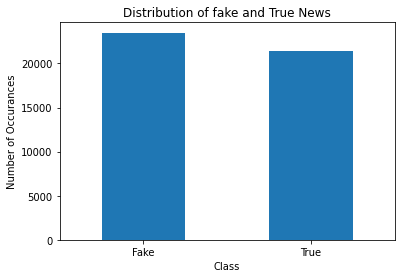

In [18]:
# plotting the distribution of true and fake news. We could see both the classes are well balanced.

count_classes = pd.value_counts(news_df['class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Distribution of fake and True News")
plt.xticks(range(2), ['Fake','True'])
plt.xlabel("Class")
plt.ylabel("Number of Occurances")

In [19]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44267 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


# Data Cleaning

In [20]:
#Replace empty string with NA Values.

news_df['text'].replace('', np.nan, inplace=True)

In [21]:
# check for NA values.
news_df['text'].isna().values.any()

True

In [22]:
# drop the NA values.
news_df.dropna(inplace=True)

In [23]:
#Removing duplicates

news_df['dup'] = news_df.duplicated(subset=['text'], keep='first')
news_df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  class    dup  
0  December 31, 2017       1  False  
1  December 29, 2017       1  False  
2  December 31, 2017       1  False  
3  December 30, 2017       1  False  
4  December 29, 2017       1  False

In [24]:
# removing the duplicate columns.

news_df = news_df[news_df['dup'] == False]

In [25]:
#deleting the column 'dup'

del news_df['dup']

In [26]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [27]:
# We could see there are no null values in the text column.
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38644 entries, 0 to 22702
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    38644 non-null  object
 1   text     38644 non-null  object
 2   subject  38644 non-null  object
 3   date     38644 non-null  object
 4   class    38644 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [28]:
news_df.shape

(38644, 5)

#  Text Preprocessing

In [29]:
# replace some words with the desired words so as to make the sentence more informative.Here "U.S" will be detected as us and will be neglected as a STOP WORD
# so that is been replaced with "America". more words can be added to the dict to improve the accuracy of the models.

import re

def replace_words(text):
    
    dict_country={'U.S.\s':'America '}
    
    for i, j in dict_country.items():
        text = re.sub(i, j,text,flags=re.IGNORECASE)
    return text

In [30]:
news_df['standardized_text']=news_df['text'].apply(replace_words)

In [31]:
# Text preprocessing like removing HTTP links,removing special characters and numbers,converting to lower case, STOPWORDS removal, lemmatization are done.

import re
import spacy
from spacy.lang.en import English
from nltk.stem.snowball import SnowballStemmer
nlp = English()
nlp2= spacy.load('en_core_web_lg')
tokenizer = nlp.tokenizer
s_stemmer=SnowballStemmer(language='english')

def preprocess(input_text):
      
    # remove the web links in the text
    http_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text_http_removed = http_pattern.sub('', input_text)
    
    # regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", text_http_removed)
    
       
    # convert to lower case
    text_to_lower_case= letters_only_text.lower()
    
    
    # word tokenization
    token_list = []
    tokens = tokenizer(text_to_lower_case)
    for token in tokens:
        token_list.append(token.text)
    
    
    #stop words removal
    stop_words_removed_text=[]
    for tok in token_list:
        if nlp.vocab[tok].is_stop == False and len(tok.strip())!=0 and len(tok)!=1:
            stop_words_removed_text.append(tok)
#     print(stop_words_removed_text)


#      stemming
#     stemmed_text=[]
#     for word in stop_words_removed_text:
#         stemmed_text.append(s_stemmer.stem(word))
#      print(stemmed_text)
    
    
    #Lemmatization
    lemmatized_text=[]
    string=''
    for w in stop_words_removed_text:
        if string=='':
            string = w
        else:
            string= string + ' ' + w 
#     print(string)
    nlp_string = nlp2(string)
    for word in nlp_string:
        lemmatized_text.append(word.lemma_)
#     print(lemmatized_text)
    

    # converting list back to string
    return " ".join(lemmatized_text)

In [32]:
# the preprocessed objective is appended to the project_df dataframe.
news_df['cleaned_text'] = news_df['standardized_text'].apply(preprocess)

In [33]:
news_df.head(10)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   
5  White House, Congress prepare for talks on spe...   
6  Trump says Russia probe will be fair, but time...   
7  Factbox: Trump on Twitter (Dec 29) - Approval ...   
8         Trump on Twitter (Dec 28) - Global Warming   
9  Alabama official to certify Senator-elect Jone...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
5  WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...  politicsNews   
6  WEST PALM BEACH, Fla (Reuters) - President Don...  politicsNews   
7  The following statements were posted to the ve...  politicsNews   
8  The following statements were posted to the ve...  politicsNews   
9  WASHINGTON (Reuters) - Alabama Secretary of St...  politicsNews   

                 date  class  \
0  December 31, 2017       1   
1  December 29, 2017       1   
2  December 31, 2017       1   
3  December 30, 2017       1   
4  December 29, 2017       1   
5  December 29, 2017       1   
6  December 29, 2017       1   
7  December 29, 2017       1   
8  December 29, 2017       1   
9  December 28, 2017       1   

                                   standardized_text  \
0  WASHINGTON (Reuters) - The head of a conservat...   
1  WASHINGTON (Reuters) - Transgender people will...   
2  WASHINGTON (Reuters) - The special counsel inv...   
3  WASHINGTON (Reuters) - Trump campaign adviser ...   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...   
5  WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...   
6  WEST PALM BEACH, Fla (Reuters) - President Don...   
7  The following statements were posted to the ve...   
8  The following statements were posted to the ve...   
9  WASHINGTON (Reuters) - Alabama Secretary of St...   

                                        cleaned_text  
0  washington reuters head conservative republica...  
1  washington reuters transgender people allow ti...  
2  washington reuters special counsel investigati...  
3  washington reuters trump campaign adviser geor...  
4  seattle washington reuters president donald tr...  
5  west palm beach fla washington reuters white h...  
6  west palm beach fla reuters president donald t...  
7  follow statement post verify twitter accounts ...  
8  follow statement post verify twitter accounts ...  
9  washington reuters alabama secretary state joh...

In [63]:
news_df_sample = news_df.sample(5000)

In [76]:
news_df_sample['class'].value_counts()

1    2723
0    2277
Name: class, dtype: int64

# TF-IDF - Text processing

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vector =TfidfVectorizer(max_features=30000,ngram_range=(1,3))

X=tfidf_vector.fit_transform(news_df.cleaned_text).toarray()

In [38]:
X.shape

(38644, 30000)

In [39]:
y=news_df['class']

In [40]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [41]:
tfidf_vector.get_feature_names()[:10]

C:\Users\adhit\anaconda3\envs\nlp_new\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa',
 'aapl',
 'aaron',
 'ab',
 'abadi',
 'abadi say',
 'abandon',
 'abbas',
 'abbasi',
 'abbott']

In [42]:
count_df = pd.DataFrame(X_train, columns=tfidf_vector.get_feature_names())

In [44]:
count_df.head()

aa  aapl  aaron   ab  abadi  abadi say  abandon  abbas  abbasi  abbott  \
0  0.0   0.0    0.0  0.0    0.0        0.0      0.0    0.0     0.0     0.0   
1  0.0   0.0    0.0  0.0    0.0        0.0      0.0    0.0     0.0     0.0   
2  0.0   0.0    0.0  0.0    0.0        0.0      0.0    0.0     0.0     0.0   
3  0.0   0.0    0.0  0.0    0.0        0.0      0.0    0.0     0.0     0.0   
4  0.0   0.0    0.0  0.0    0.0        0.0      0.0    0.0     0.0     0.0   

   abc  abc news  abc news report  abc week  abcpolitic  abd  abd rabbu  \
0  0.0       0.0              0.0       0.0         0.0  0.0        0.0   
1  0.0       0.0              0.0       0.0         0.0  0.0        0.0   
2  0.0       0.0              0.0       0.0         0.0  0.0        0.0   
3  0.0       0.0              0.0       0.0         0.0  0.0        0.0   
4  0.0       0.0              0.0       0.0         0.0  0.0        0.0   

   abd rabbu mansour  abdel  abdel fattah  abdel fattah al  abdicate  abduct  \
0                0.0    0.0           0.0              0.0       0.0     0.0   
1                0.0    0.0           0.0              0.0       0.0     0.0   
2                0.0    0.0           0.0              0.0       0.0     0.0   
3                0.0    0.0           0.0              0.0       0.0     0.0   
4                0.0    0.0           0.0              0.0       0.0     0.0   

   abduction  abdul  abdullah  abdullah saleh  abe  abe say  abedin  abet  \
0        0.0    0.0       0.0             0.0  0.0      0.0     0.0   0.0   
1        0.0    0.0       0.0             0.0  0.0      0.0     0.0   0.0   
2        0.0    0.0       0.0             0.0  0.0      0.0     0.0   0.0   
3        0.0    0.0       0.0             0.0  0.0      0.0     0.0   0.0   
4        0.0    0.0       0.0             0.0  0.0      0.0     0.0   0.0   

   abhorrent  abid  abide  ability  able  able find  able use  able vote  \
0        0.0   0.0    0.0      0.0   0.0        0.0       0.0        0.0   
1        0.0   0.0    0.0      0.0   0.0        0.0       0.0        0.0   
2        0.0   0.0    0.0      0.0   0.0        0.0       0.0        0.0   
3        0.0   0.0    0.0      0.0   0.0        0.0       0.0        0.0   
4        0.0   0.0    0.0      0.0   0.0        0.0       0.0        0.0   

   abnormality  aboard  aboard air  aboard air force  abolish  abort  aborted  \
0          0.0     0.0         0.0               0.0      0.0    0.0      0.0   
1          0.0     0.0         0.0               0.0      0.0    0.0      0.0   
2          0.0     0.0         0.0               0.0      0.0    0.0      0.0   
3          0.0     0.0         0.0               0.0      0.0    0.0      0.0   
4          0.0     0.0         0.0               0.0      0.0    0.0      0.0   

   abortion  abortion clinic  abortion law  abortion provider  abortion right  \
0       0.0              0.0           0.0                0.0             0.0   
1       0.0              0.0           0.0                0.0             0.0   
2       0.0              0.0           0.0                0.0             0.0   
3       0.0              0.0           0.0                0.0             0.0   
4       0.0              0.0           0.0                0.0             0.0   

   abortive  abraham  abraham lincoln  abrams  abroad  abrupt  abruptly  \
0       0.0      0.0              0.0     0.0     0.0     0.0       0.0   
1       0.0      0.0              0.0     0.0     0.0     0.0       0.0   
2       0.0      0.0              0.0     0.0     0.0     0.0       0.0   
3       0.0      0.0              0.0     0.0     0.0     0.0       0.0   
4       0.0      0.0              0.0     0.0     0.0     0.0       0.0   

   absence  absent  absentee  absentee ballot  absolute  absolutely  \
0      0.0     0.0       0.0              0.0       0.0         0.0   
1      0.0     0.0       0.0              0.0       0.0         0.0   
2      0.0     0.0       0.0              0.0

# Model Training

# 1) Multinominal Naive Bayes

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [77]:
from sklearn import metrics
import itertools
from sklearn.naive_bayes import MultinomialNB

# initializing NB model
model_nb=MultinomialNB()

In [78]:
# training the NB Model with training data.
model_nb.fit(X_train, y_train)
pred = model_nb.predict(X_test)

accuracy:   0.949
precision:   0.957
recall :   0.950
f1 score :   0.954


Confusion matrix, without normalization


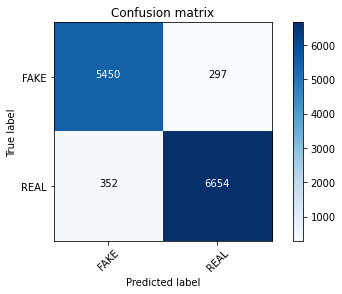

In [66]:
# Evaluation Metrics 
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score,f1_score
accuracy_s = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % accuracy_s)

precision_s = precision_score(y_test, pred)
print("precision:   %0.3f" % precision_s)

recall_s = recall_score(y_test, pred)
print("recall :   %0.3f" % recall_s)

f1_s = f1_score(y_test,pred)
print("f1 score :   %0.3f" % f1_s)
print("\n")

cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [83]:
# creating a dataframe to see the original and the predicted values.
predicted_values = y_test
predicted_values = pd.DataFrame(columns=['original_values','model_predicted_values'])
predicted_values['original_values']=y_test
predicted_values['model_predicted_values']=pred


# 2) XGBoost

In [79]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier

# initializing and fitting the XGBoost model.

model_xg = XGBClassifier()
model_xg.fit(X_train, y_train)

C:\Users\adhit\anaconda3\envs\nlp_new\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\adhit\anaconda3\envs\nlp_new\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:25:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
# make predictions
pred_xg = model_xg.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(pred_xg, y_test)))

Mean Absolute Error : 0.0030581039755351682


accuracy:   0.997
precision:   0.997
recall :   0.998
f1 score :   0.997


Confusion matrix, without normalization


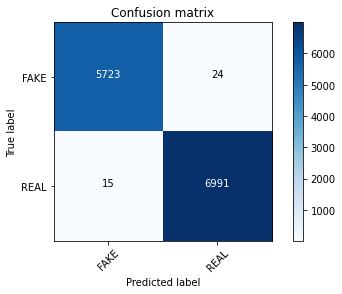

In [89]:
# Evaluation Metrics 
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score,f1_score

accuracy_s = metrics.accuracy_score(y_test, pred_xg)
print("accuracy:   %0.3f" % accuracy_s)

precision_s = precision_score(y_test, pred_xg)
print("precision:   %0.3f" % precision_s)

recall_s = recall_score(y_test, pred_xg)
print("recall :   %0.3f" % recall_s)

f1_s = f1_score(y_test,pred_xg)
print("f1 score :   %0.3f" % f1_s)
print("\n")

cm = metrics.confusion_matrix(y_test, pred_xg)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

# LSTM

In [90]:
import tensorflow as tf

In [91]:
tf.__version__

'2.8.0'

In [145]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [146]:
### Vocabulary size
voc_size=3000

# One hot representation

In [160]:
# since the whole data took lot of time to complete. I have resampled the data with 5000 rows.
news_df_resample=news_df.sample(5000)

In [162]:
news_df_resample['class'].value_counts()

1    2736
0    2264
Name: class, dtype: int64

In [163]:
# converting the words to one hot representation.
onehot_repr=[one_hot(words,voc_size)for words in news_df_resample['cleaned_text']] 

In [164]:
#Checking the maximum length of the text field.
length=[]
for i in onehot_repr:
    length.append(len(i))

print(max(length))

4415


# embedding representation

In [165]:
#converting the one hot representation to embedded document.

sent_length=4415
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ...  651 2150  376]
 [   0    0    0 ... 2105  918 2939]
 [   0    0    0 ... 2106  992 2046]
 ...
 [   0    0    0 ... 2371 1480 2510]
 [   0    0    0 ...  558   55  796]
 [   0    0    0 ...  210 2507 1195]]


In [166]:
embedded_docs[0]

array([   0,    0,    0, ...,  651, 2150,  376])

# Creating Model

In [167]:
## Creating model
embedding_vector_features=30
model_lstm=Sequential()
model_lstm.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model_lstm.add(LSTM(100))
model_lstm.add(Dense(1,activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model_lstm.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 4415, 30)          90000     
                                                                 
 lstm_5 (LSTM)               (None, 100)               52400     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
None


In [168]:
len(embedded_docs),y.shape

(5000, (38644,))

In [169]:
X_final=np.array(embedded_docs)
y_final=np.array(news_df_resample['class'])

X_final.shape,y_final.shape

((5000, 4415), (5000,))

In [170]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Model Training

In [171]:
# Model Training
model_lstm.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=10)

Epoch 1/10
335/335 [==============================] - 444s 1s/step - loss: 0.3402 - accuracy: 0.8618 - val_loss: 0.1696 - val_accuracy: 0.9364
Epoch 2/10
335/335 [==============================] - 443s 1s/step - loss: 0.1134 - accuracy: 0.9636 - val_loss: 0.1661 - val_accuracy: 0.9412
Epoch 3/10
335/335 [==============================] - 442s 1s/step - loss: 0.0569 - accuracy: 0.9815 - val_loss: 0.1877 - val_accuracy: 0.9303
Epoch 4/10
335/335 [==============================] - 443s 1s/step - loss: 0.0465 - accuracy: 0.9848 - val_loss: 0.2321 - val_accuracy: 0.9303
Epoch 5/10
335/335 [==============================] - 439s 1s/step - loss: 0.0293 - accuracy: 0.9916 - val_loss: 0.2654 - val_accuracy: 0.9370
Epoch 6/10
335/335 [==============================] - 437s 1s/step - loss: 0.0241 - accuracy: 0.9931 - val_loss: 0.2609 - val_accuracy: 0.9267
Epoch 7/10
335/335 [==============================] - 444s 1s/step - loss: 0.0111 - accuracy: 0.9967 - val_loss: 0.2998 - val_accuracy: 0.9303

# Prediction

In [172]:
y_pred = (model_lstm.predict(X_test) > 0.5).astype("int32")

In [173]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[642,  88],
       [ 41, 879]], dtype=int64)

# Summary:

In [ ]:
# The True and Fake data is fetched from Kaggle, added with a class column (0 for fake news and 1 for True news) and merged into a single dataframe.

# The data is cleaned:
# -NA values are removed.
# -Empty string values are checked and removed
# -Duplicates are removed

# Preprocessed:
# -Removed HTTP links
# -Removed STOPWORDS
# -lemmatized
# -Numbers and special characters are removed.

# The following Machine learning text classification models are used to train the data.

# Multinomial Naive Bayes :

# This is one of the very popular supervised learning method that is used for the analysis of text data. Since the Naive Bayes assusmes every word in a document is
# independent of every other word, It doesnot consider the semantice meaning of the sentence while categorizing. The training time of the Naive Bayes model is
# very fast. (Accuracy score is 94.9%)

# XGBoost:

# XGBoost is one of the most successful ensemble method for classification as well as regression problems. It will generate a final model based on individual models.
# XGBoost is more accurate with a accuracy score of 99.7% than the Naive Bayes model 

# LSTM: (Long short-term memory):
# It is a variant of RNN and it leanrs by considering the sequence of the words in a sentence to classify them. It takes considerably more time than the other 2 models.

# References

In [ ]:
# https://github.com/chasethompson/fake-news-nlp/blob/master/Untitled.ipynb
# https://github.com/krishnaik06/Fake-News-Classifier/blob/master/FakeNewsClassifier%20TFIDF.ipynb